In [1]:
import pandas as pd
import fiona
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
from IPython.display import display

**churn_usersprofile**: Socio-demographic characterization and the residence area of the bus users. Information like the gender, age class, county of origin of bus users can be very useful for this challenge.  
**churn_od**: Demand for public transportation in each county of origin and its respective parish of destination.  

**Goals**: Create a framework that will allow to measure the increase and decrease the passengers of public transport towards cities that are more inclusive and sustainable.  
**Outcome**: Given the public transports users’ profile in two periods, the aggregated OD matrix, and any other external or derived data, this exercise should produce the following major outcomes: Identify churn profiles and drivers, propose measures to win back lost segments and their expected impact.

In [2]:
up = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/pse/Churn_UsersProfile.txt',
                                 encoding = "ISO-8859-1",
                                sep='|')
od = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/pse/Churn_OD.txt',
                                 encoding = "ISO-8859-1",
                                sep='|', dtype={'Dicofre_ParishCode_of_Public_Transportation': str})

In [3]:
up.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Period,GenderDescription,AgeClassDescription,Average_BusUsers_per_Day
0,R1 - AM Lisboa,Lisboa,Amadora,Sep-19 to Feb-20,Female,15-24,294.194206
1,R1 - AM Lisboa,Lisboa,Amadora,Sep-19 to Feb-20,Female,25-34,1081.652817


In [4]:
od.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Dicofre_ParishCode_of_Public_Transportation,Demand_weight
0,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,110608,0.307323
1,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,110639,0.069997


In [5]:
print(up.shape, od.shape)

(544, 7) (2253, 8)


In [6]:
set(up.Period)

{'Sep-19 to Feb-20', 'Sep-20 to Jan-21'}

# Analyzing Users Profile

In [7]:
up.columns

Index(['Region_of_Origin', 'District_of_Origin', 'County_of_Origin', 'Period',
       'GenderDescription', 'AgeClassDescription', 'Average_BusUsers_per_Day'],
      dtype='object')

In [8]:
up.County_of_Origin.unique()

array(['Amadora', 'Cascais', 'Lisboa', 'Loures', 'Mafra', 'Odivelas',
       'Oeiras', 'Sintra', 'Vila Franca de Xira', 'Alcochete', 'Almada',
       'Barreiro', 'Moita', 'Montijo', 'Palmela', 'Seixal', 'Sesimbra',
       'Setúbal', 'Espinho', 'Oliveira de Azeméis',
       'Santa Maria da Feira', 'Gondomar', 'Maia', 'Matosinhos',
       'Paredes', 'Porto', 'Póvoa de Varzim', 'Santo Tirso', 'Trofa',
       'Valongo', 'Vila do Conde', 'Vila Nova de Gaia', 'Arouca',
       'São João da Madeira', 'Vale de Cambra'], dtype=object)

 - We have single values for each combination of Period, County, Gender and Age

In [9]:
profiles_gb = up.groupby(['County_of_Origin','GenderDescription', 'AgeClassDescription']).size().to_frame()

In [10]:
single_period = profiles_gb[profiles_gb.values==1].reset_index()

## Find Variation Whenever Possible

In [11]:
two_periods = up.merge(single_period, how='outer', indicator=True).query('_merge != "both"').drop(['_merge', 0], 1)

In [12]:
two_periods.groupby(['Period']).size()

Period
Sep-19 to Feb-20    239
Sep-20 to Jan-21    239
dtype: int64

In [13]:
df_first = two_periods[two_periods.Period == 'Sep-19 to Feb-20'].drop('Period', axis=1).rename(columns={'Average_BusUsers_per_Day': 'Average_BusUsers_per_Day_first'})
df_second = two_periods[two_periods.Period == 'Sep-20 to Jan-21'].drop('Period', axis=1).rename(columns={'Average_BusUsers_per_Day': 'Average_BusUsers_per_Day_second'})

In [14]:
both_averages = df_first.merge(df_second, how='outer', indicator=True).drop('_merge', 1)

In [15]:
change_df = both_averages
change_df['Change'] = change_df.Average_BusUsers_per_Day_first - change_df.Average_BusUsers_per_Day_second
change_df = change_df.drop(['Average_BusUsers_per_Day_first', 'Average_BusUsers_per_Day_second'], 1)

In [16]:
change_df =change_df.sort_values('Change', ascending=False)

# Insights from Change table

In [17]:
for col in change_df.columns.drop('Change'):
    display(change_df.groupby(col)['Change'].mean().to_frame().sort_values('Change', ascending=False))

,Change
Region_of_Origin,
R2 - AM Porto,1367.856185
R1 - AM Lisboa,331.812747


,Change
District_of_Origin,
Porto,1580.489648
Lisboa,434.074012
Aveiro,222.906770
Setúbal,168.194724


,Change
County_of_Origin,
Gondomar,3655.146825
Maia,2776.060462
Porto,2189.972712
Matosinhos,861.287204
Lisboa,843.418032
Oliveira de Azeméis,726.730692
Vila Nova de Gaia,705.161995
Odivelas,656.785136
Cascais,580.510053


,Change
GenderDescription,
Male,702.848084
Female,680.833001


,Change
AgeClassDescription,
65+,3521.857010
15-24,548.103674
55-64,534.336945
25-34,400.486989
45-54,380.801390
35-44,165.373038


# Analyzing Demand Table

In [18]:
od.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Dicofre_ParishCode_of_Public_Transportation,Demand_weight
0,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,110608,0.307323
1,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,110639,0.069997


In [19]:
asa = fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_3.shp")

In [20]:
freguesias = pd.read_excel('https://dados.gov.pt/pt/datasets/r/ec6ef805-c278-4b4d-ba9b-3116264f68b4', engine="openpyxl")[['dicofre', 'freguesia']]

In [21]:
od_freguesia = pd.merge(od, freguesias,
                    how='outer',left_on=['Dicofre_ParishCode_of_Public_Transportation'],
                    right_on=['dicofre']).dropna().drop(['dicofre', 'Dicofre_ParishCode_of_Public_Transportation'],1)

In [22]:
od_freguesia.head(2)

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Demand_weight,freguesia
0,R1 - AM Lisboa,Lisboa,Amadora,R1 - AM Lisboa,LISBOA,LISBOA,0.307323,Benfica
1,R1 - AM Lisboa,Lisboa,Cascais,R1 - AM Lisboa,LISBOA,LISBOA,0.068546,Benfica


In [32]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape

In [34]:
in_freguesias = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_3.shp")
    if pol['properties']['NAME_3'] in od_freguesia.freguesia.unique()])
not_in_freguesias = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_3.shp")
    if pol['properties']['NAME_3'] not in od_freguesia.freguesia.unique()])
all_freguesias = MultiPolygon(
    [shape(pol['geometry']) for pol in fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_3.shp")])

In [35]:
mp = all_freguesias

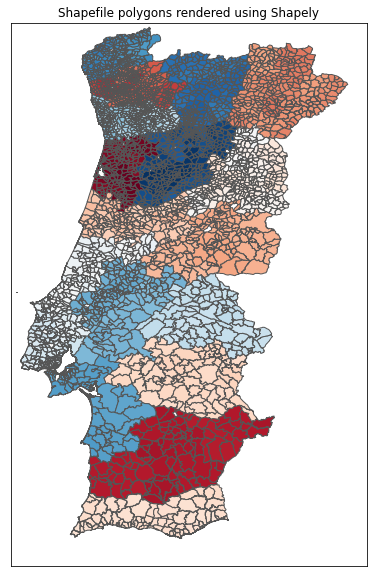

In [38]:
cm = plt.get_cmap('RdBu')
num_colours = len(mp)
 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = mp.bounds
w, h = maxx - minx, maxy - miny
#ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
#ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
ax.set_xlim(-9.6, -6)
ax.set_ylim(36.7, 42.2)
ax.set_aspect(1)

patches = []
for idx, p in enumerate(mp):
    colour = cm(1. * idx / num_colours)
    patches.append(PolygonPatch(p, fc=colour, ec='#555555', alpha=1., zorder=1))
ax.add_collection(PatchCollection(patches, match_original=True))
ax.set_xticks([])
ax.set_yticks([])
plt.title("Shapefile polygons rendered using Shapely")
plt.show()

In [ ]:
freguesias_shapes = fiona.open("/home/primity/terras/gadm36_PRT_shp/gadm36_PRT_3.shp")

freguesias_dict = {}
for shp in freguesias_shapes:
    freguesias_dict[shp['properties']['NAME_3']] = shp['geometry']['coordinates'][0] 

freguesias_plot = {}
for key, value in freguesias_dict.items():
    freguesias_plot[key] = [[point[0] for point in value], [point[1] for point in value] ]

In [ ]:
def plot_freguesias(freguesias_plot, xlim, ylim):
    plt.figure(figsize=(5,10))
    plt.xlim(xlim)
    plt.ylim(ylim)
    for name, fr in freguesias_plot.items():
        if name in od_freguesia.freguesia.unique():
            c = 'red'
            lw=1
        else:
            c = 'blue'
            lw=0.1
        plt.plot(fr[0], fr[1], color=c , linewidth=lw)
    plt.show()

In [ ]:
plot_freguesias(freguesias_plot, (-9.6, -6), (36.7, 42.2))

In [ ]:
# Demands sum to a value very close to 1 on the county level
od_freguesia.groupby(['County_of_Origin'])['Demand_weight'].sum().to_frame().sort_values('Demand_weight', ascending=False).sample(5)

# Joining Both Tables

We can now have estimated demands for each county to parish pair, for every demographic available. This way we can see which routrs are avings strong churn for different demographics

In [ ]:
es_demands = pd.merge(od_freguesia, change_df,
                    on=['County_of_Origin']).drop(['Region_of_Origin_x', 'District_of_Origin_x'], 1)

In [ ]:
es_demands['Demand_change'] = es_demands.Demand_weight * es_demands.Change

In [ ]:
es_demands.sort_values('Demand_change', ascending = True).head(7)

In [ ]:
es_demands.Demand_change.describe()